# LAB 5

In [3]:
%pip install torch scikit-learn scipy statsmodels matplotlib

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.5 MB 12.6 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.5 MB 13.0 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.5 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 15.6 MB/s eta 0:00:00
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. DANE I MODELE KLASYCZNE

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [90]:
X_noisy, y_noisy = make_regression(
    n_samples=100,
    n_features=2,
    noise=0,
    random_state=42
)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}


In [91]:
results = {}
for name, model in models.items():
    model.fit(X_noisy, y_noisy)
    y_pred = model.predict(X_noisy)
    results[name] = {
        'R²': r2_score(y_noisy, y_noisy),
        'MSE': mean_squared_error(y_noisy, y_noisy),
        'MAE': mean_absolute_error(y_noisy, y_noisy),
        'model': model
    }
    print(f"{name}: R²={results[name]['R²']:.3f}, MSE={results[name]['MSE']:.2f}, MAE={results[name]['MAE']:.2f}")

Linear: R²=1.000, MSE=0.00, MAE=0.00
Ridge: R²=1.000, MSE=0.00, MAE=0.00
Lasso: R²=1.000, MSE=0.00, MAE=0.00


## 2. WIZUALIZACJA

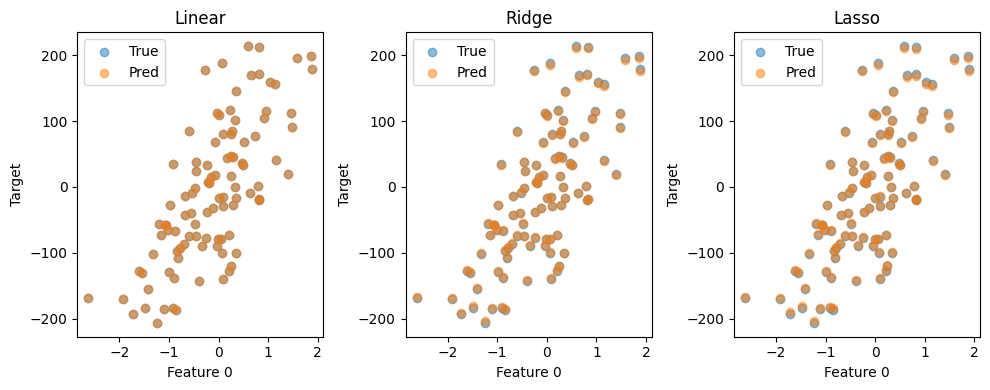

In [92]:
plt.figure(figsize=(10, 4))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(X_noisy[:, 0], y_noisy, alpha=0.5, label='True')
    plt.scatter(X_noisy[:, 0], res['model'].predict(X_noisy), alpha=0.5, label='Pred')
    plt.xlabel('Feature 0')
    plt.ylabel('Target')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()

## 3. WAŻNOŚĆ CECH


Ważność cech: [86.57154877 73.36639489]


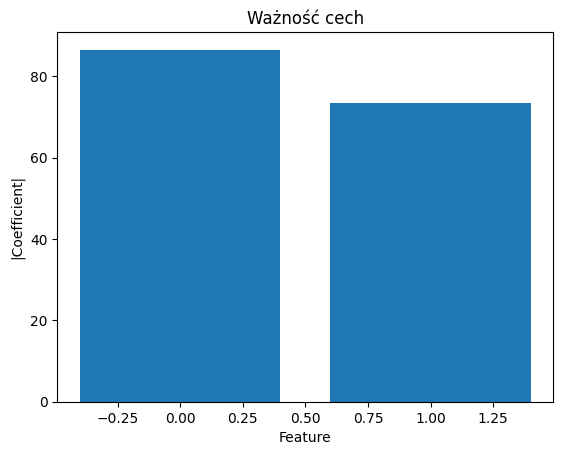

In [93]:
ridge = results['Ridge']['model']
feature_importance = np.abs(ridge.coef_)
print("\nWażność cech:", feature_importance)

plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature')
plt.ylabel('|Coefficient|')
plt.title('Ważność cech')
plt.show()

## 4. ANALIZA RESZT

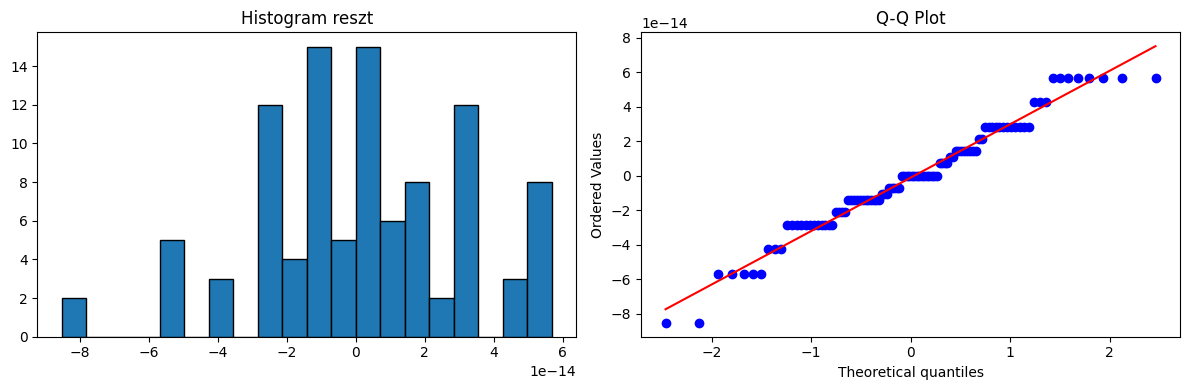


Shapiro-Wilk: stat=0.9709, p=0.0259 (brak normalności)
Durbin-Watson: 1.9776 (brak autokorelacji ≈ 2.0)


In [95]:
residuals = y_noisy - results['Linear']['model'].predict(X_noisy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram reszt')
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.tight_layout()
plt.show()

stat, p = shapiro(residuals)
dw_stat = durbin_watson(residuals)
print(f"\nShapiro-Wilk: stat={stat:.4f}, p={p:.4f} {'(normalność OK)' if p > 0.05 else '(brak normalności)'}")
print(f"Durbin-Watson: {dw_stat:.4f} (brak autokorelacji ≈ 2.0)")

## 5. SIEĆ NEURONOWA - PYTORCH

Epoch 20/200, Train Loss: 0.0009, Val Loss: 0.0010
Epoch 40/200, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 60/200, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 80/200, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 100/200, Train Loss: 0.0002, Val Loss: 0.0003
Epoch 120/200, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 140/200, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 160/200, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 180/200, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 200/200, Train Loss: 0.0000, Val Loss: 0.0001

Sieć neuronowa MAE: 0.007


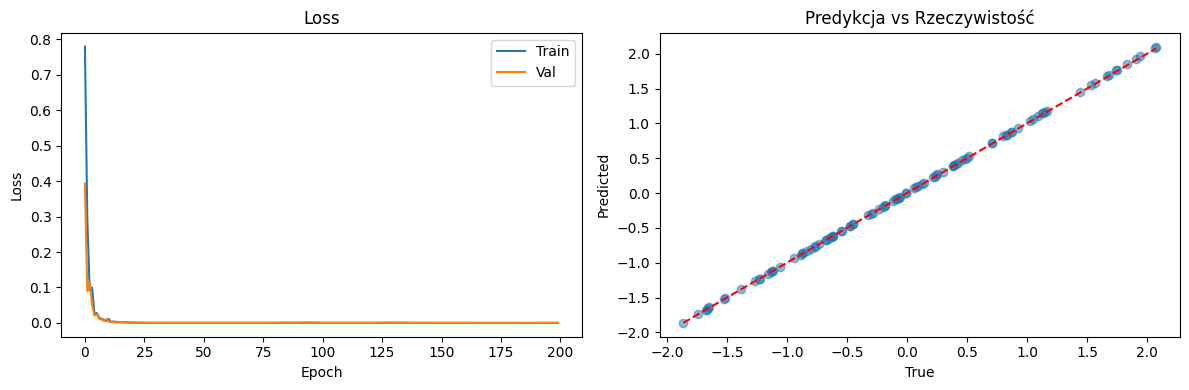

In [99]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_noisy)
X_test_scaled = scaler_X.transform(X_noisy)
y_train_scaled = scaler_y.fit_transform(y_noisy.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_noisy.reshape(-1, 1)).flatten()

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

model = RegressionNN(X_noisy.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 200
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)

    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_mae = torch.mean(torch.abs(predictions - y_test_tensor))
    print(f"\nSieć neuronowa MAE: {test_mae:.3f}")

# Wizualizacja
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.scatter(y_test_scaled, predictions.numpy(), alpha=0.5)
plt.plot([y_test_scaled.min(), y_test_scaled.max()],
         [y_test_scaled.min(), y_test_scaled.max()], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Predykcja vs Rzeczywistość')
plt.tight_layout()
plt.show()

## 6. POJĘCIA

In [98]:
n_samples = len(X_noisy)
batch_size = 32
iterations_per_epoch = int(np.ceil(n_samples / batch_size))
print(f"\n=== BATCH SIZE, EPOCH, ITERATION ===")
print(f"Próbek: {n_samples}, Batch: {batch_size}, Epok: {epochs}")
print(f"Iteracji/epoka: {iterations_per_epoch}")
print(f"Łącznie iteracji: {iterations_per_epoch * epochs}")


=== BATCH SIZE, EPOCH, ITERATION ===
Próbek: 100, Batch: 32, Epok: 100
Iteracji/epoka: 4
Łącznie iteracji: 400
